In [1]:
import polars as pl
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import numpy as np
import logging
import random

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.random.set_seed(seed)
print(tf.__version__)

2024-06-15 14:42:54.020744: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 14:42:54.084984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 14:42:55.112159: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [2]:
from polimi.utils.tf_models.utils.build_sequences import build_history_seq

history = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/history.parquet')
behaviors = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/train/behaviors.parquet')
articles = pl.read_parquet('/home/ubuntu/dataset/ebnerd_small/articles.parquet')

history_seq = build_history_seq(history, articles)

history_seq.head(3)

Memory usage of dataframe is 40.75 MB
Memory usage after optimization is: 5.12 MB
Decreased by 87.4%


user_id,sentiment_label,weekday,hour_group,read_time,category,scroll_percentage,premium,topics_0,topics_1,topics_2,topics_3,topics_4,topics_5,topics_6,topics_7,topics_8,topics_9,topics_10,topics_11,topics_12,topics_13,topics_14,topics_15,topics_16,topics_17,topics_18,topics_19,topics_20,topics_21,topics_22,topics_23,topics_24,topics_25,topics_26,topics_27,topics_28,…,subcategory_137,subcategory_138,subcategory_139,subcategory_140,subcategory_141,subcategory_142,subcategory_143,subcategory_144,subcategory_145,subcategory_146,subcategory_147,subcategory_148,subcategory_149,subcategory_150,subcategory_151,subcategory_152,subcategory_153,subcategory_154,subcategory_155,subcategory_156,subcategory_157,subcategory_158,subcategory_159,subcategory_160,subcategory_161,subcategory_162,subcategory_163,subcategory_164,subcategory_165,subcategory_166,subcategory_167,subcategory_168,subcategory_169,subcategory_170,subcategory_171,subcategory_172,subcategory_173
u32,list[i8],list[i8],list[i8],list[f32],list[i8],list[f32],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],…,list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8],list[i8]
497320,"[1, 3, … 2]","[5, 5, … 4]","[0, 0, … 0]","[698.0, 136.0, … 161.0]","[4, 7, … 6]","[100.0, 100.0, … 100.0]","[1, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 1]","[0, 0, … 0]","[0, 1, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[1, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 1]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 1, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[1, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]",…,"[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]"
446852,"[2, 1, … 1]","[4, 4, … 3]","[3, 5, … 3]","[2.0, 2.0, … 43.0]","[7, 5, … 5]","[0.0, 0.0, … 85.0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[1, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[1, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 1, … 1]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]",…,"[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]"
696298,"[2, 2, … 1]","[4, 4, … 3]","[1, 3, … 4]","[0.0, 8.0, … 1.0]","[4, 4, … 5]","[0.0, 30.0, … 100.0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]","[0, 0, … 0]"

In [3]:
from polimi.utils.tf_models.utils.build_sequences import build_sequences_seq
train_data = build_sequences_seq(history_seq=history_seq[:100], window=20, stride=5)
train_data['topics'][0].shape

ImportError: cannot import name 'build_sequences_seq' from 'polimi.utils.tf_models.utils.build_sequences' (/home/ubuntu/RecSysChallenge2024/src/polimi/utils/tf_models/utils/build_sequences.py)

In [ ]:
train_data.keys()

dict_keys(['topics', 'subcategory', 'category', 'weekday', 'hour_group', 'sentiment_label', 'numerical'])

In [ ]:
train_data['topics'][0][0].shape[1], train_data['subcategory'][0][0].shape[1], train_data['category'][0].shape

(78, 174, (4118, 20, 1))

In [1]:
from polimi.utils.tf_models import TemporalHistorySequenceModel, TemporalHistoryClassificationModel
from polimi.utils._polars import reduce_polars_df_memory_size

model = TemporalHistorySequenceModel(
    seq_embedding_dims={
        # adding, for the moment, one dim more to cover missings in non one-hot vectors
        'Input_topics': (78, 10, True),
        'Input_subcategory': (174, 10, True),
        'Input_category': (26, 10, False),
        'Input_weekday': (8, 3, False),
        'Input_hour_group': (7, 3, False),
        'Input_sentiment_label': (4, 2, False)
    },
    seq_numerical_features=['scroll_percentage', 'read_time', 'premium'],
    n_recurrent_layers=1,
    recurrent_embedding_dim=64,
    l1_lambda=1e-4,
    l2_lambda=1e-4,
)

2024-06-15 14:44:22.869103: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 14:44:22.937847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 14:44:23.932479: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
model._build()

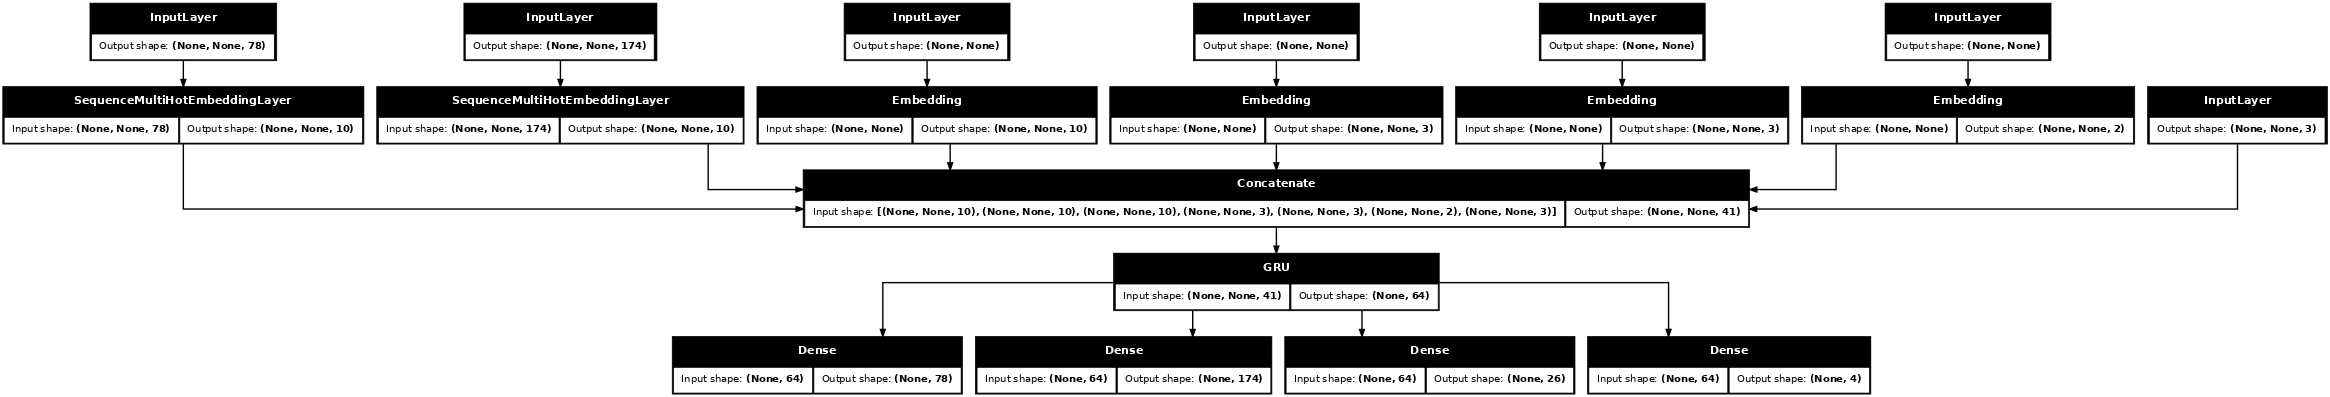

In [3]:
model.plot()

In [ ]:
inputs = {f'Input_{name}': train_data[name][0] for name in train_data.keys()}
targets = {f'Output_{name}': train_data[name][1] for name in ['topics', 'category', 'subcategory']}

targets['Output_category'] = tfk.ops.squeeze(tfk.ops.one_hot(targets['Output_category'], num_classes=26, axis=-1))

NameError: name 'train_data' is not defined

In [ ]:
window = 20
training_dataset = tf.data.Dataset.from_tensors((inputs, targets)).batch(64).shuffle()

NameError: name 'tf' is not defined

In [ ]:
model.fit(
    train_dataset=training_dataset,
    batch_size=64,
    epochs=10,
    # target for (topics, subcategory, category)
    loss={
        'Output_topics': tfk.losses.BinaryCrossentropy(), 
        'Output_subcategory': tfk.losses.BinaryCrossentropy(), 
        'Output_category': tfk.losses.CategoricalCrossentropy()
    },
    loss_weights={
        'Output_topics': 0.5, 
        'Output_subcategory': 0.1, 
        'Output_category': 0.4
    },
    optimizer=tfk.optimizers.Adam(learning_rate=1e-4)
)

Epoch 1/10


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 5.7227
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - loss: 5.7706
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 5.8108
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - loss: 5.8697
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 5.9469
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - loss: 5.9851
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - loss: 6.0389
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - loss: 6.0949
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - loss: 6.1687
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - loss: 6.2035
